In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import astropy.units as u
import matplotlib.pyplot as plt
import yaml

from gammapy.datasets import MapDataset
from gammapy.maps import Map
from gammapy.catalog import SourceCatalogHGPS
from gammapy.modeling.models import SkyModel, TemplateSpatialModel, PowerLawNormSpectralModel, Models

In [2]:
def open_dataset(name, hessera):
    dataset= MapDataset.read(f'{mainpath_hess}/{name}.fits')
    dataset.mask_safe = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
    dataset.mask_safe &= dataset.counts.geom.region_mask(f"galactic;circle(0, 0, 3)")
    
    dataset.mask_fit = Map.from_geom(geom=dataset.counts.geom, data=np.ones_like(dataset.counts.data).astype(bool))   
    dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(358.71, -0.64, 0.7)")

    if hessera == 'hess1':
        dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(359.5, -0.2, 0.2)")
        dataset.mask_fit &= ~dataset.counts.geom.region_mask(f"galactic;circle(358.45, 0.15, 0.35)")

    model_path = f'{mainpath_hess}/fitted_model_{name}.yml'
    if os.path.exists(model_path):
        dataset.models = Models.read(model_path)
    return dataset

In [3]:
hesseras=['hess1', 'hess2', 'hess1u']
muoneff_flag= True
edisp = True

info_list = [] #hessera, muoneff, edisp, name

mainpath_hess = '/home/vault/caph/mppi062h/repositories/GC/HESS'

for hessera in hesseras:
    if hessera =='hess1u':
        muoneff_flag=False
        
    if hessera == 'hess1':
        name_afterFermi='v1'
        for name_afterFermi_idx in range(3):
            name = f'20220702_{hessera}_muoneff{muoneff_flag}_edisp{edisp}_afterFermi{name_afterFermi}_{name_afterFermi_idx}'
            info_list.append([hessera, muoneff_flag, edisp, name])
    else:
        name = f'20220702_{hessera}_muoneff{muoneff_flag}_edisp{edisp}'
        info_list.append([hessera, muoneff_flag, edisp, name])
    
datasets_hess = []
for i in range(len(info_list)):
    datasets_hess.append(open_dataset(info_list[i][3], info_list[i][0])) 

In [4]:
central_source='HESS J1745-290'
colors = ['navy', 'C0', 'C1', 'C2', 'C5']

x_axis = datasets_hess[0].counts.geom.axes['energy'].center.value
energy_bounds = [0.3, 100] * u.TeV
sed_type = "e2dnde"

catalog = SourceCatalogHGPS()
catalog_model = catalog[central_source].sky_model()

# plots

The first plot is the motivation: it shows that the different datasets could have a different cutoff for the central source

Text(0.5, 1.0, 'HESS J1745-290')

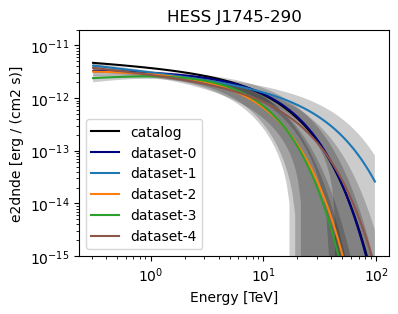

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

catalog_model.spectral_model.plot(ax=ax, color='black',
        energy_bounds=energy_bounds, sed_type=sed_type, label='catalog')
    
for idx, hess in enumerate(datasets_hess):
    hess.models[central_source].spectral_model.plot(ax=ax, color=colors[idx],
        energy_bounds=energy_bounds, sed_type=sed_type, label=f'dataset-{idx}')
    hess.models[central_source].spectral_model.plot_error(ax=ax, energy_bounds=energy_bounds, sed_type=sed_type)
plt.legend(loc='lower left')
plt.ylim(1e-15, 2e-11)
plt.title(central_source)

Text(0.5, 1.0, 'for fixed spectral index')

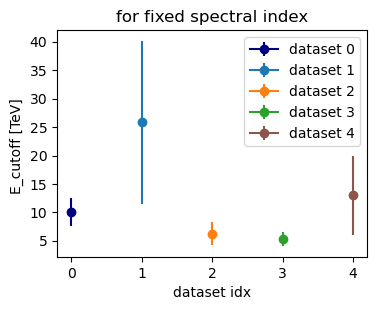

In [6]:
fig, ax = plt.subplots(1,1, figsize=(4, 3), dpi=100)

for idx, hess in enumerate(datasets_hess):
    label=f'dataset {idx}'
    par='lambda_'
    e_cutoff = 1/hess.models[central_source].spectral_model.parameters[par].value
    e_cutoff_error = e_cutoff**2*hess.models[central_source].spectral_model.parameters[par].error
    plt.errorbar(idx, e_cutoff, 
                 yerr=e_cutoff_error,
                 color=colors[idx], label=label, marker='o')
ax.set_xlabel('dataset idx')
ax.set_ylabel('E_cutoff [TeV] ')
plt.legend()
plt.title(f'for fixed spectral index')